In [ ]:
from deap import base, creator, tools, algorithms
import numpy as np
import random
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, precision_recall_curve, confusion_matrix, roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import shap
from sklearn.inspection import permutation_importance

In [2]:
df = pd.read_csv(r"C:\Users\Robyi\Documents\Data Science Dataset\wine.csv")
df.head()

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline,Customer_Segment
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,1
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,1
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,1
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,1
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Alcohol               178 non-null    float64
 1   Malic_Acid            178 non-null    float64
 2   Ash                   178 non-null    float64
 3   Ash_Alcanity          178 non-null    float64
 4   Magnesium             178 non-null    int64  
 5   Total_Phenols         178 non-null    float64
 6   Flavanoids            178 non-null    float64
 7   Nonflavanoid_Phenols  178 non-null    float64
 8   Proanthocyanins       178 non-null    float64
 9   Color_Intensity       178 non-null    float64
 10  Hue                   178 non-null    float64
 11  OD280                 178 non-null    float64
 12  Proline               178 non-null    int64  
 13  Customer_Segment      178 non-null    int64  
dtypes: float64(11), int64(3)
memory usage: 19.6 KB


In [4]:
x = df.drop(columns=['Customer_Segment'])
y = df['Customer_Segment']

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.35, random_state=42)

In [14]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

c:\Users\Robyi\AppData\Local\Programs\Python\Python311\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Users\Robyi\AppData\Local\Programs\Python\Python311\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [15]:
def create_toolbox(x_train, y_train, x_test, y_test):
    toolbox = base.Toolbox()
    
   
    toolbox.register("attr_alpha", np.random.uniform, 0, 10)
    
    toolbox.register("attr_norm", np.random.choice, [True, False])
    
   
    toolbox.register("individual", tools.initCycle, creator.Individual,
                     (toolbox.attr_alpha, toolbox.attr_norm), n=1)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    
    def evaluate(individual):
        alpha, norm = individual
        model = ComplementNB(alpha=alpha, norm=norm)
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        return (accuracy_score(y_test, y_pred),)
    

    toolbox.register("evaluate", evaluate)
    toolbox.register("mate", tools.cxTwoPoint)
    toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
    toolbox.register("select", tools.selTournament, tournsize=3)
    
    return toolbox

In [16]:
def run_ga(x_train, y_train, x_test, y_test, pop_size=50, n_generations=10):
    toolbox = create_toolbox(x_train, y_train, x_test, y_test)
    

    pop = toolbox.population(n=pop_size)
    hof = tools.HallOfFame(1)
    
    
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)
    
   
    algorithms.eaSimple(pop, toolbox, 
                       cxpb=0.7, 
                       mutpb=0.2,  
                       ngen=n_generations, 
                       stats=stats,
                       halloffame=hof,
                       verbose=True)
    
    return hof[0]

In [17]:
best_hyperparams = run_ga(x_train, y_train, x_test, y_test)
print(f"Best Hyperparameters: Alpha={best_hyperparams[0]}, Norm={best_hyperparams[1]}")

gen	nevals	avg     	std     	min     	max     
0  	50    	0.553333	0.157903	0.333333	0.666667
1  	37    	0.64    	0.0904311	0.333333	0.666667
2  	37    	0.666667	1.11022e-16	0.666667	0.666667
3  	32    	0.666667	1.11022e-16	0.666667	0.666667
4  	32    	0.666667	1.11022e-16	0.666667	0.666667
5  	40    	0.666667	1.11022e-16	0.666667	0.666667
6  	32    	0.66    	0.0466667  	0.333333	0.666667
7  	35    	0.66    	0.0466667  	0.333333	0.666667
8  	41    	0.666667	1.11022e-16	0.666667	0.666667
9  	34    	0.666667	1.11022e-16	0.666667	0.666667
10 	35    	0.66    	0.0466667  	0.333333	0.666667
Best Hyperparameters: Alpha=3.0075418171011945, Norm=False


In [ ]:
best_alpha, best_norm = best_hyperparams
best_model = ComplementNB(alpha=best_alpha, norm=best_norm)

best_model.fit(x_train, y_train)

y_pred = best_model.predict(x_test)
print(y_pred)

In [ ]:
proba = best_model.predict_proba(x_test)
print(proba)

In [ ]:
prediksi = pd.read_csv(r"C:\Users\Robyi\Documents\Data Science Dataset\winepredict.csv")
prediksi.head()

In [ ]:
y_prediksi = best_model.predict(prediksi)
probabilitas_prediksi = best_model.predict_proba(prediksi)
print(y_prediksi)
print(probabilitas_prediksi)

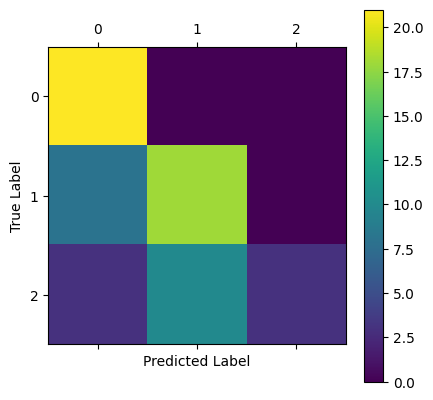

In [19]:
matrix = confusion_matrix(y_test, y_pred)

plt.matshow(matrix)
plt.colorbar()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [20]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.6666666666666666

Classification Report:
              precision    recall  f1-score   support

           1       0.66      1.00      0.79        21
           2       0.64      0.69      0.67        26
           3       1.00      0.19      0.32        16

    accuracy                           0.67        63
   macro avg       0.77      0.63      0.59        63
weighted avg       0.74      0.67      0.62        63



In [ ]:
cv_scores = cross_val_score(best_model, x_train, y_train, cv=5, scoring='accuracy')
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Accuracy:", np.mean(cv_scores))

Text(113.9222222222222, 0.5, 'true value')

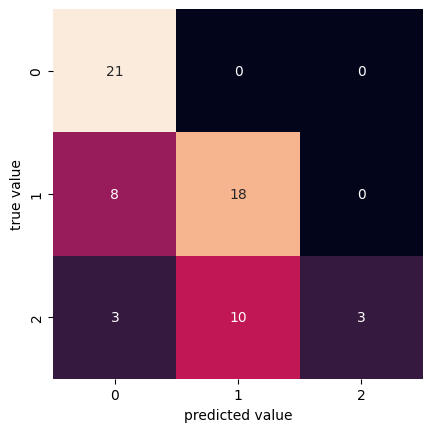

In [21]:
sns.heatmap(matrix, square  =True, annot = True, cbar = False)
plt.xlabel('predicted value')
plt.ylabel('true value')

0.9309310458626568


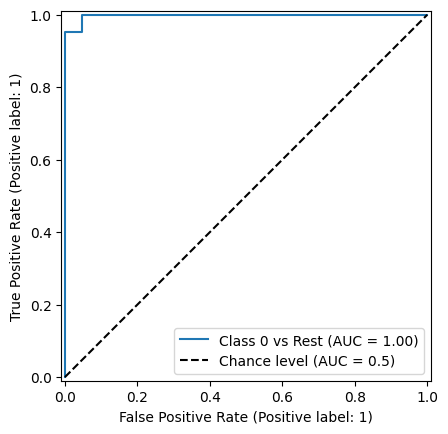

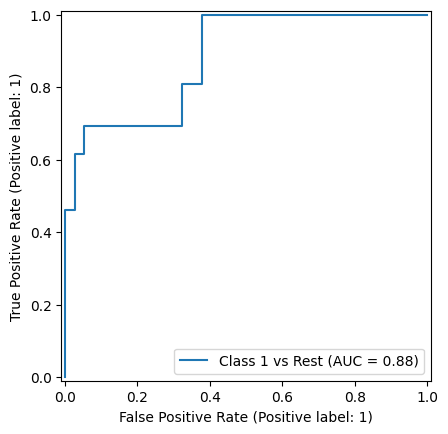

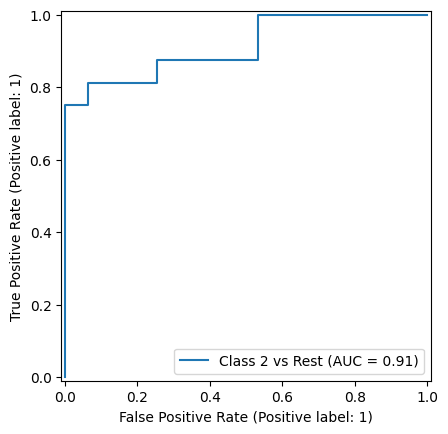

In [23]:
y_prob = best_model.predict_proba(x_test)

roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class='ovr')
print(roc_auc_ovr)

y_test_bin = label_binarize(y_test, classes = best_model.classes_)
n_classes = y_test_bin.shape[1]

for i in range(n_classes):
    RocCurveDisplay.from_predictions(
        y_test_bin[:,i],
        y_prob[:,i],
        name=f"Class {i} vs Rest",
        plot_chance_level =(i==0)
    )

plt.show()

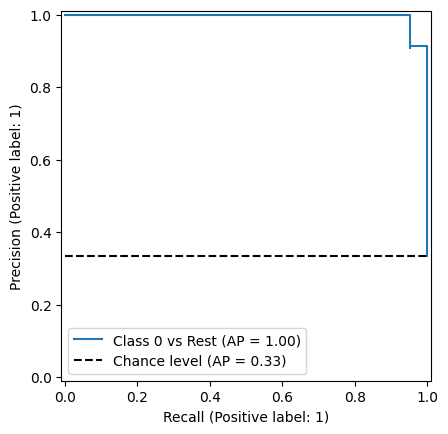

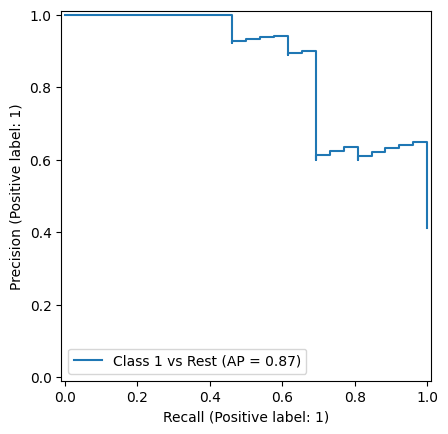

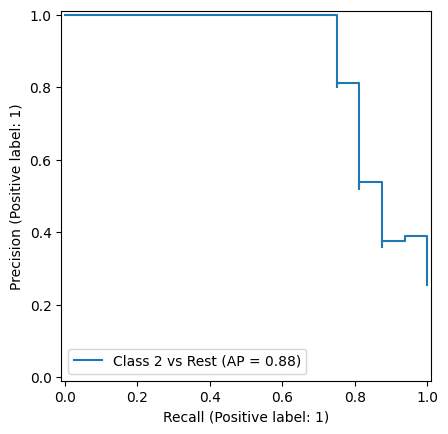

In [24]:
precision = dict()
recall = dict()
pr_auc = dict()

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:,i], y_prob[:,i])
    pr_auc[i] = auc(recall[i], precision[i])
    PrecisionRecallDisplay.from_predictions(
        y_test_bin[:,i],
        y_prob[:,i],
        name=f"Class {i} vs Rest",
        plot_chance_level =(i==0)
    )

plt.show()

In [ ]:
perm_importance = permutation_importance(best_model, x_test, y_test, scoring="accuracy")
feature_importance = perm_importance.importances_mean

feature_names = x_train.columns

plt.figure(figsize=(6, 4))
sns.barplot(x=feature_importance, y=feature_names, orient="h", palette="viridis")
plt.xlabel("Feature Importance Score")
plt.ylabel("Feature")
plt.tight_layout()

In [ ]:
explainer = shap.Explainer(best_model.predict, x_train)
shap_values = explainer(x_test)

In [ ]:
shap.summary_plot(shap_values, x_test, feature_names=x.columns)
shap.plots.bar(shap_values)